In [1]:
!ultralytics version

8.3.245


In [2]:
# Import và Kiểm tra phần cứng
import torch
import os
from ultralytics import YOLO

from IPython.display import clear_output
clear_output()

print(f"PyTorch Version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"Đã kết nối GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Đang chạy bằng CPU. Hãy kiểm tra lại Driver NVIDIA.")

PyTorch Version: 2.8.0+cu126
Đã kết nối GPU: NVIDIA GeForce GTX 1660 Ti


In [3]:
# Tải và Xử lý dữ liệu
import kagglehub
import shutil
import random
import os
from pathlib import Path

# --- 1. Tải hoặc xác định dữ liệu ---
print("Đang tải/kiểm tra dữ liệu từ Kaggle...")
# Tải về 
download_path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print(f"Đường dẫn tải về gốc: {download_path}")

# --- 2. Quét folder garbage-dataset ---
print("Đang quét folder")

data_root = None

target_classes = {'battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash'}

for root, dirs, files in os.walk(download_path):
    # Kiểm tra xem folder hiện tại có chứa các folder rác không
    current_dirs = set(d.lower() for d in dirs)
    
    if target_classes.issubset(current_dirs):
        data_root = Path(root)
        print(f"ĐÃ TÌM THẤY dữ liệu tại: {data_root}")
        break

if data_root is None:
    print("LỖI: Không tìm thấy folder dữ liệu nào khớp với cấu trúc trong ảnh!")
else:
    # --- 3. Chia dữ liệu (80% Train - 10% Val - 10% Test) ---
    base_dir = Path("datasets/waste_cls")
    
    # Reset thư mục đích
    if base_dir.exists():
        shutil.rmtree(base_dir)
        
    print(f"Đang copy và chia dữ liệu sang: {base_dir.resolve()}")
    
    # Tạo các thư mục đích
    for split in ['train', 'val', 'test']:
        for cls in os.listdir(data_root):
            if (data_root / cls).is_dir():
                (base_dir / split / cls).mkdir(parents=True, exist_ok=True)

    # Thực hiện chia và copy
    total_count = 0
    classes_found = [d for d in os.listdir(data_root) if (data_root / d).is_dir()]
    
    for cls in classes_found:
        src_folder = data_root / cls
        # Lấy tất cả ảnh (hỗ trợ jpg, png, jpeg, webp...)
        images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))]
        
        if not images:
            continue
            
        random.shuffle(images)
        count = len(images)
        total_count += count
        
        # Tỷ lệ 8:1:1
        train_end = int(count * 0.8)
        val_end = int(count * 0.9)
        
        splits = {
            'train': images[:train_end],
            'val':   images[train_end:val_end],
            'test':  images[val_end:]
        }
        
        # Copy file
        for split_name, imgs in splits.items():
            dst_folder = base_dir / split_name / cls
            for img_name in imgs:
                shutil.copy2(src_folder / img_name, dst_folder / img_name)
                
    print(f"HOÀN TẤT! Tổng cộng {total_count} ảnh đã được xử lý.")
    print(f"Danh sách lớp: {classes_found}")

Đang tải/kiểm tra dữ liệu từ Kaggle...
Đường dẫn tải về gốc: C:\Users\Windows\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\10
Đang quét folder
ĐÃ TÌM THẤY dữ liệu tại: C:\Users\Windows\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\10
Đang copy và chia dữ liệu sang: D:\Code\python\machine-learning\datasets\waste_cls
HOÀN TẤT! Tổng cộng 20212 ảnh đã được xử lý.
Danh sách lớp: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [3]:
from ultralytics import YOLO

# 1. Load model từ file
model_path = 'yolov12n-cls.pt' 
model = YOLO(model_path) 

print(f"Bắt đầu Train {model_path} cho bài toán Classification")

# 2. Bắt đầu Train
results = model.train(
    data="datasets/waste_cls",
    imgsz=224,             
    epochs=60,
    batch=32,              
    device=0,

    freeze=0,

    optimizer="auto",
    lr0=0.01,
    cos_lr=True,

    dropout=0.1,

    augment=True,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=25.0,
    flipud=0.5,
    fliplr=0.5,           
    
    patience=15,
    workers=4,
    plots=True,           
    project='waste_project',   
    name='yolov12_cls_run'     
)

Bắt đầu Train yolov12n-cls.pt cho bài toán Classification
Ultralytics 8.3.245  Python-3.9.25 torch-2.8.0+cu126 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=datasets/waste_cls, degrees=25.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov12n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov12_cls_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=aut

1. Biểu đồ Huấn luyện (Loss & Accuracy):


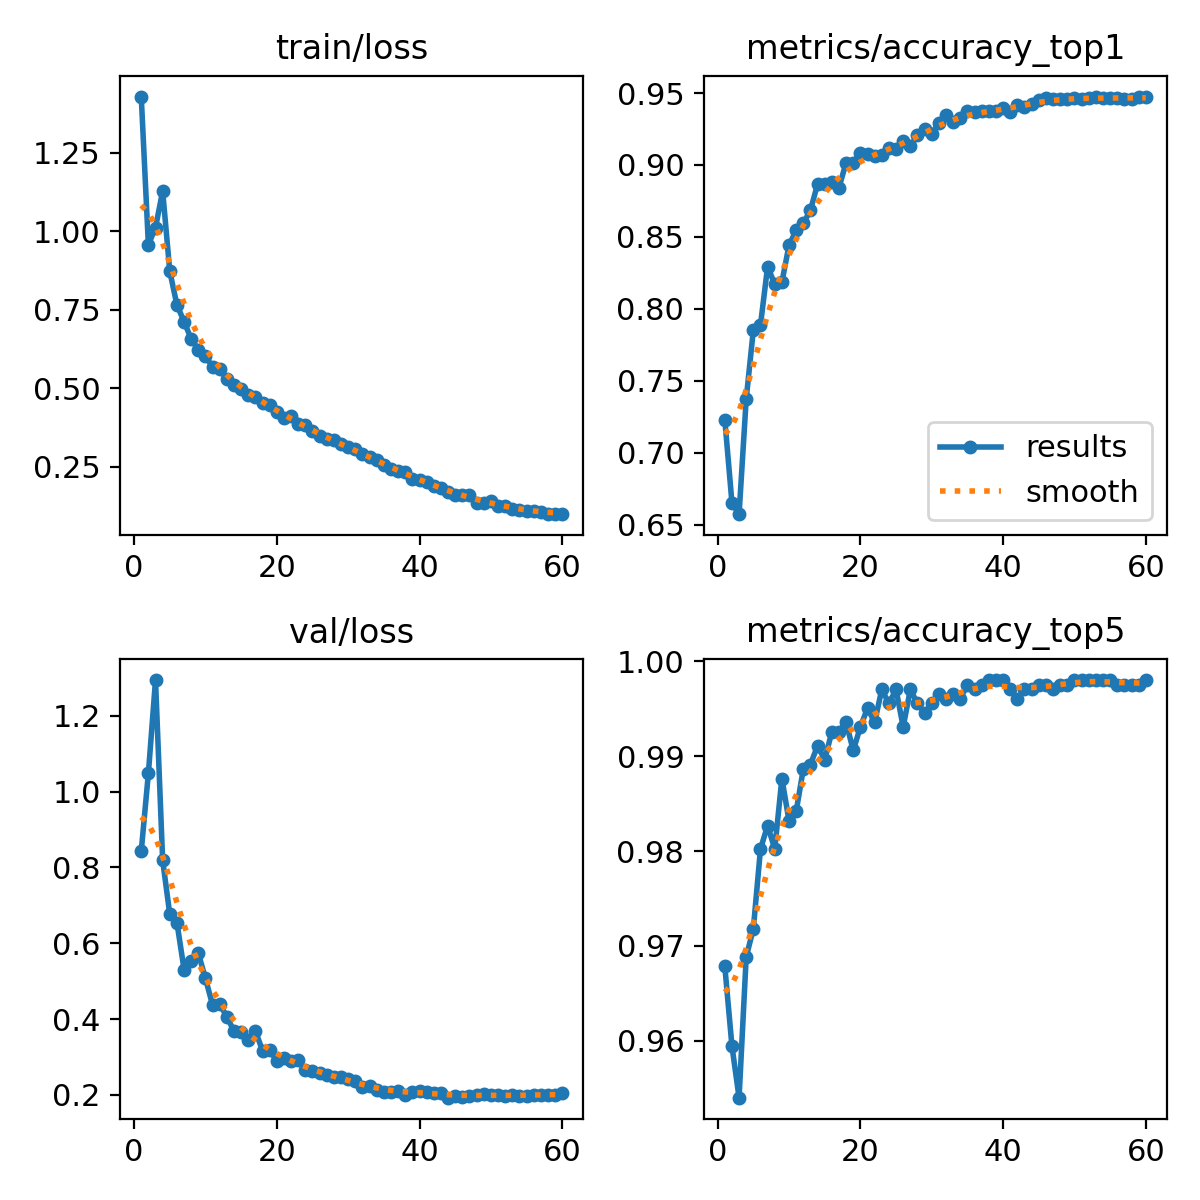


2. Ma trận nhầm lẫn (Confusion Matrix):


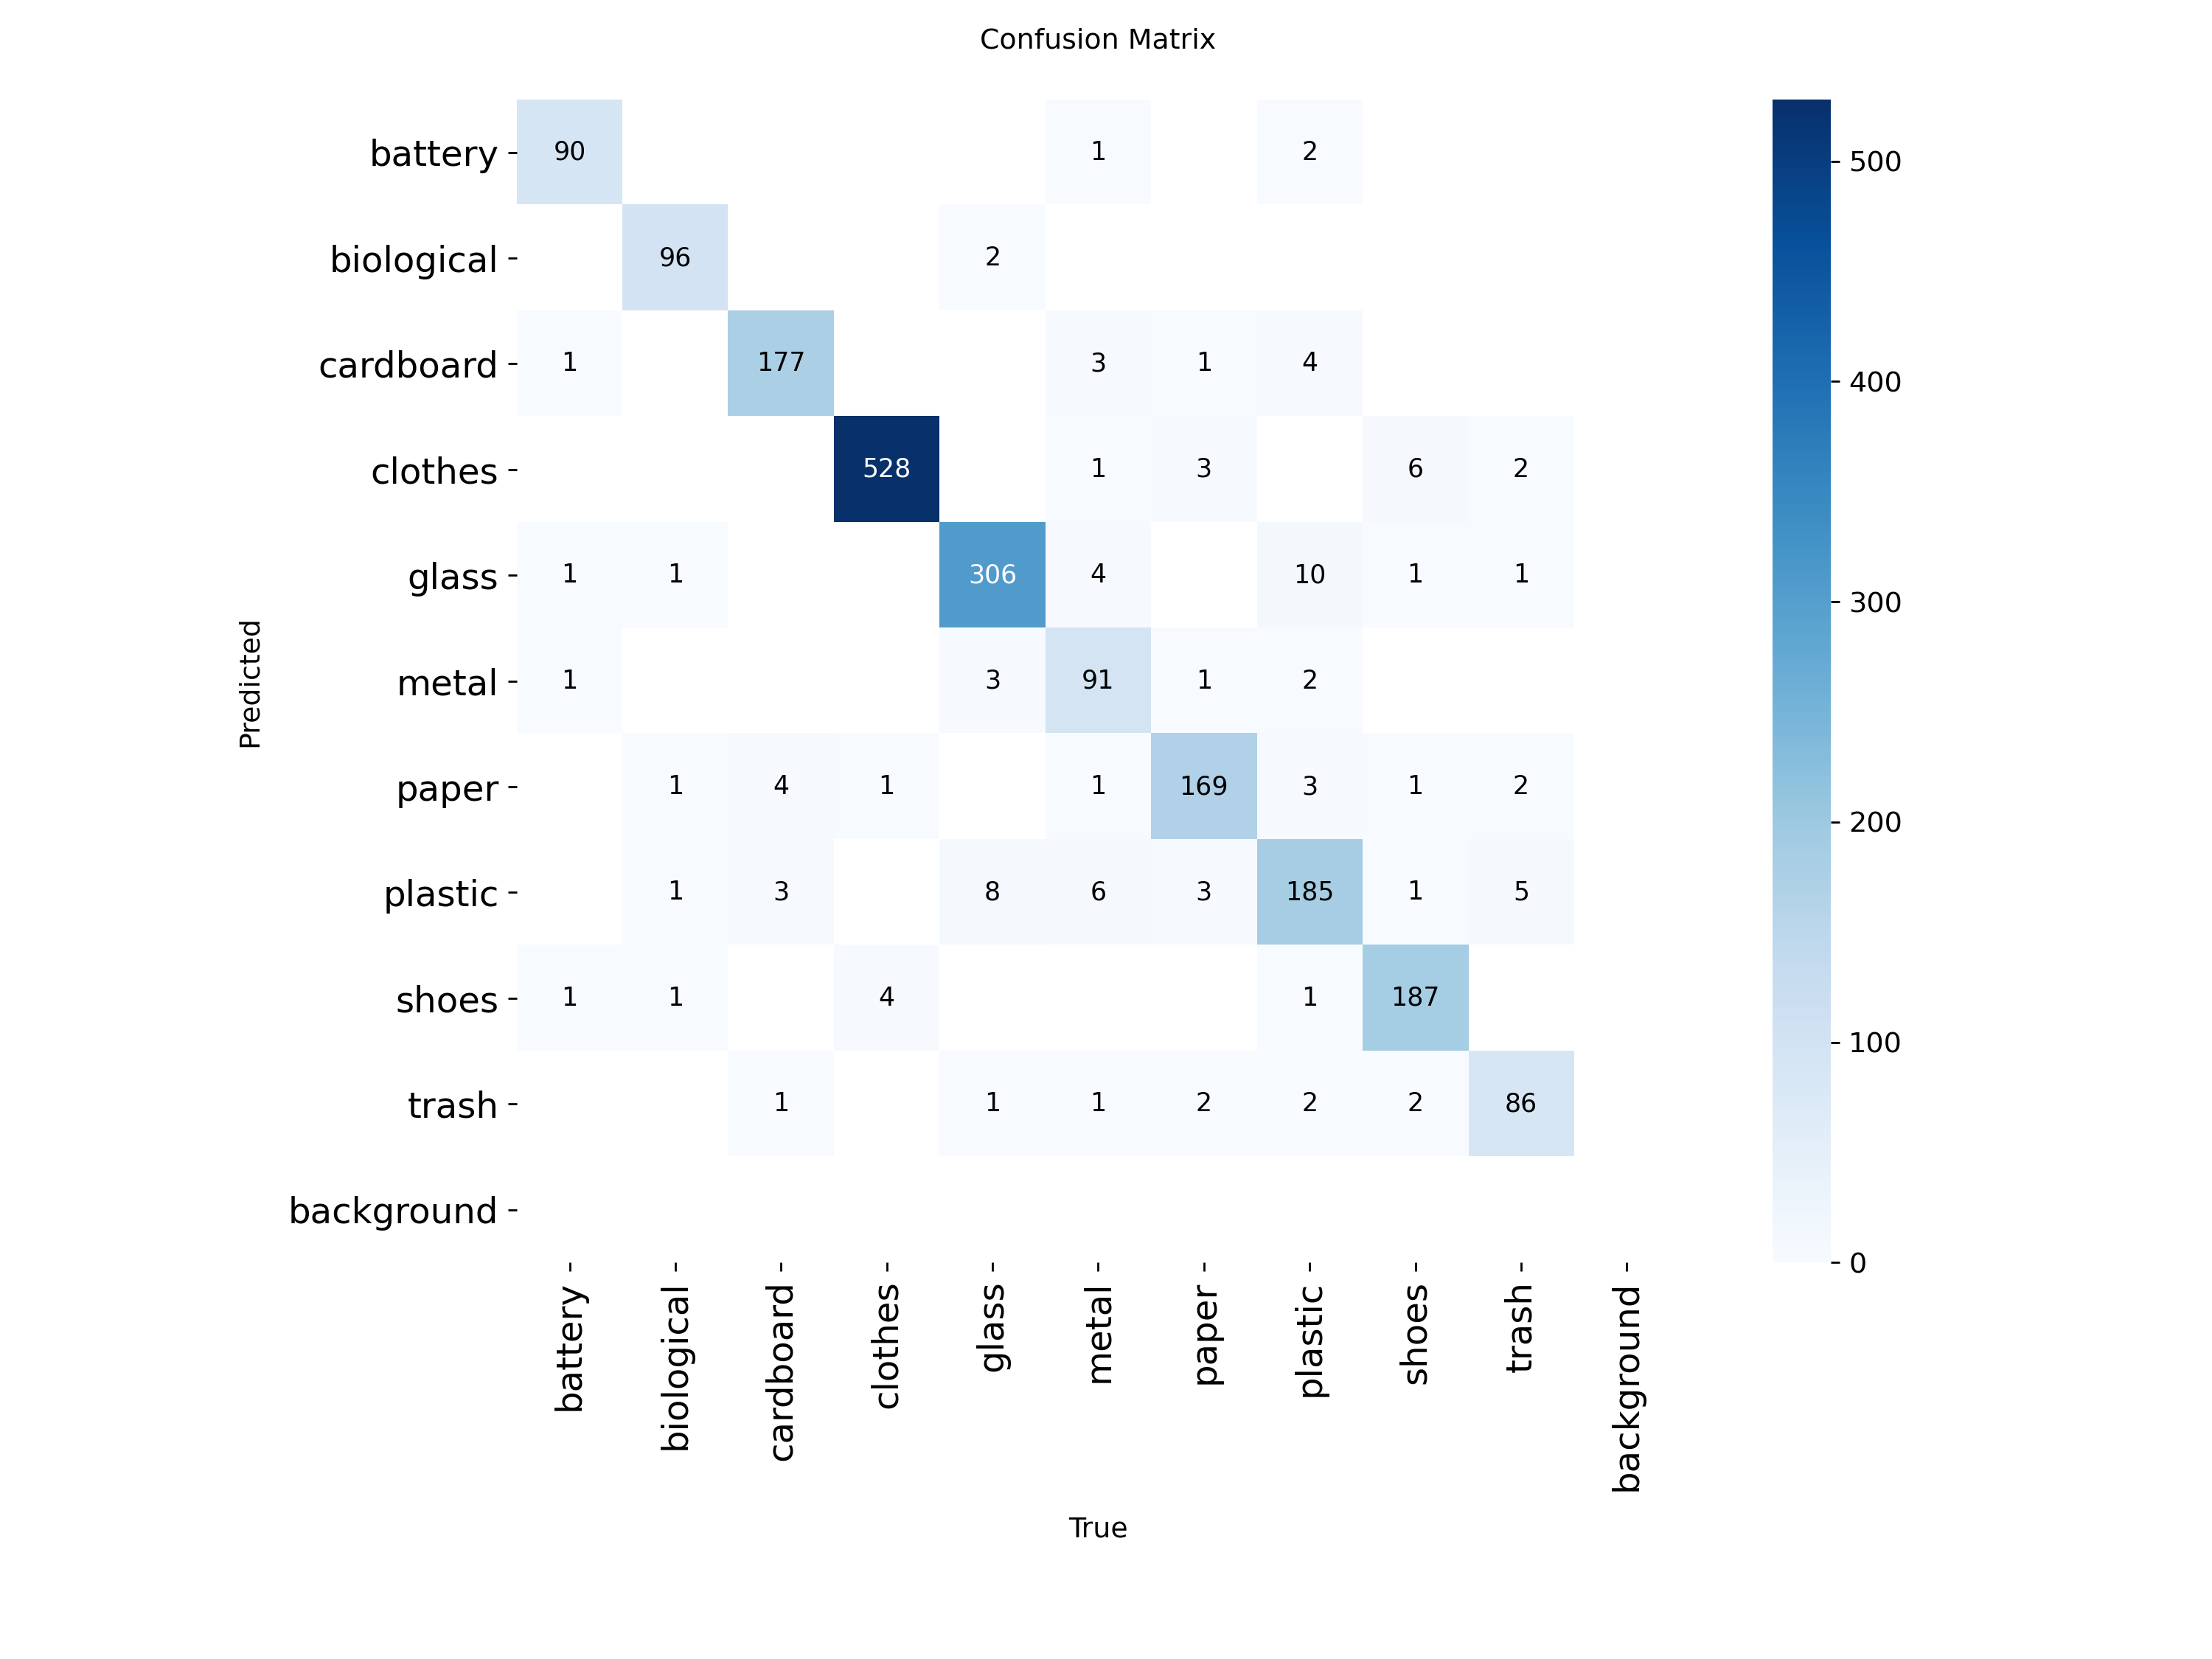

In [5]:
from IPython.display import Image, display, HTML

# --- CẤU HÌNH ĐƯỜNG DẪN ---
run_path = 'waste_project/yolov12_cls_run'

# --- 1. BIỂU ĐỒ QUÁ TRÌNH HUẤN LUYỆN (LOSS & ACCURACY) ---
results_img = os.path.join(run_path, 'results.png')

print(f"1. Biểu đồ Huấn luyện (Loss & Accuracy):")
if os.path.exists(results_img):
    display(Image(filename=results_img, width=800))
else:
    print(f"Không tìm thấy file ảnh tại: {results_img}")

# --- 2. MA TRẬN NHẦM LẪN (CONFUSION MATRIX) ---
cm_img = os.path.join(run_path, 'confusion_matrix.png')

print(f"\n2. Ma trận nhầm lẫn (Confusion Matrix):")
if os.path.exists(cm_img):
    display(Image(filename=cm_img, width=800))
else:
    # Thử tìm bản chuấn hóa nếu bản thường không có
    cm_norm_img = os.path.join(run_path, 'confusion_matrix_normalized.png')
    if os.path.exists(cm_norm_img):
        display(Image(filename=cm_norm_img, width=600))
    else:
        print("Không tìm thấy ảnh Confusion Matrix.")

1. Đang quét tìm file best.pt...
Đã tìm thấy model: waste_project\yolov12_cls_run\weights\best.pt
2. Đang kiểm tra folder: datasets/waste_cls/test
   Tìm thấy các lớp: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
   Tổng số ảnh tìm thấy: 2025
3. Đang chạy dự đoán (Vui lòng chờ)...

Tốc độ trung bình: 35.59 FPS (28.09 ms/ảnh)

4. Đang vẽ biểu đồ ...

=== BÁO CÁO KẾT QUẢ ===
              precision    recall  f1-score   support

     battery       0.91      0.93      0.92        95
  biological       0.99      0.96      0.97       100
   cardboard       0.98      0.95      0.96       186
     clothes       0.98      0.99      0.98       533
       glass       0.93      0.93      0.93       320
       metal       0.85      0.88      0.86       108
       paper       0.90      0.96      0.93       179
     plastic       0.92      0.84      0.88       210
       shoes       0.93      0.93      0.93       198
       trash       0.8

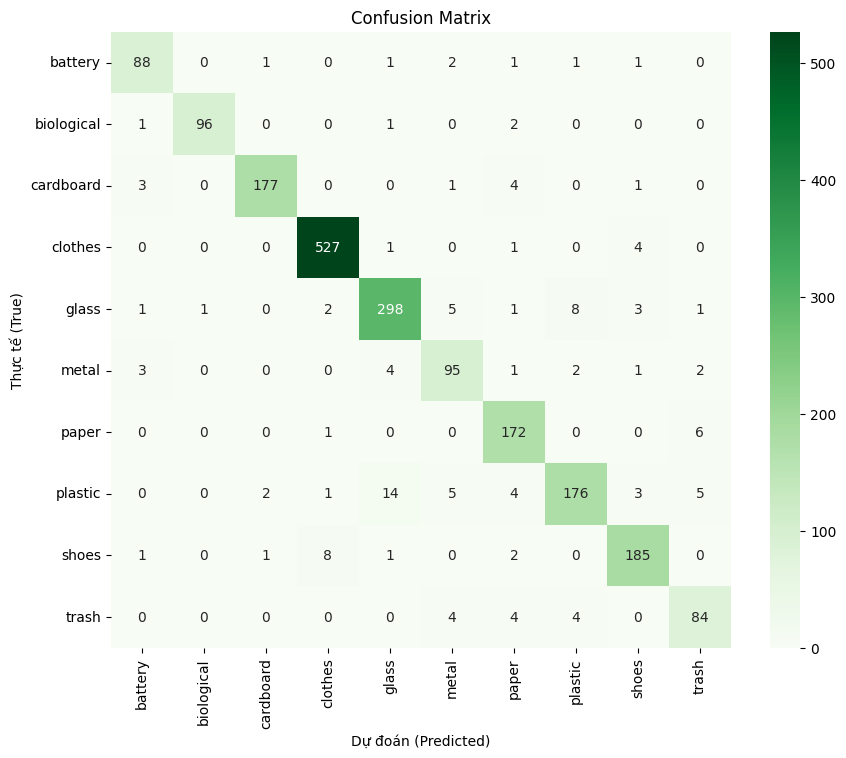

In [6]:
%matplotlib inline 

from ultralytics import YOLO
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time

# --- BƯỚC 1: TÌM FILE MODEL ---
print("1. Đang quét tìm file best.pt...")
found_files = glob.glob('waste_project/**/best.pt', recursive=True)

if not found_files:
    print("Lỗi: Không tìm thấy file 'best.pt' nào. Hãy kiểm tra lại việc train.")
else:
    model_path = found_files[-1]
    print(f"Đã tìm thấy model: {model_path}")
    
    # Load model
    model = YOLO(model_path)
    test_dir = 'datasets/waste_cls/test'

    # --- BƯỚC 2: KIỂM TRA DỮ LIỆU ---
    print(f"2. Đang kiểm tra folder: {test_dir}")
    
    if not os.path.exists(test_dir):
        print(f"Lỗi: Đường dẫn {test_dir} không tồn tại!")
    else:
        # Lấy danh sách ảnh và nhãn
        image_paths = []
        y_true = []
        class_names = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
        
        print(f"   Tìm thấy các lớp: {class_names}")

        for label in class_names:
            folder_path = os.path.join(test_dir, label)
            # Tìm cả đuôi hoa và thường
            for ext in ('*.png', '*.jpg', '*.jpeg'):
                for img_file in glob.glob(os.path.join(folder_path, ext)):
                    image_paths.append(img_file)
                    y_true.append(label)
        
        print(f"   Tổng số ảnh tìm thấy: {len(image_paths)}")

        if len(image_paths) == 0:
            print("Không có ảnh nào để test. Code sẽ dừng tại đây.")
        else:
            # --- BƯỚC 3: DỰ ĐOÁN ---
            print("3. Đang chạy dự đoán (Vui lòng chờ)...")
            
            y_pred = []
            inference_times = []
            for img_path in image_paths:
                t0 = time.time()
                # Dự đoán
                results = model(img_path, verbose=False)
                
                t1 = time.time()
                inference_times.append((t1 - t0) * 1000)
                
                # Lấy kết quả
                pred_idx = results[0].probs.top1
                y_pred.append(results[0].names[pred_idx])
                
            # Tính FPS
            avg_latency = np.mean(inference_times)
            fps = 1000 / avg_latency
            print(f"\nTốc độ trung bình: {fps:.2f} FPS ({avg_latency:.2f} ms/ảnh)")

            # --- BƯỚC 4: VẼ BIỂU ĐỒ ---
            print("\n4. Đang vẽ biểu đồ ...")
            
            try:
                # In báo cáo dạng chữ
                print("\n=== BÁO CÁO KẾT QUẢ ===")
                print(classification_report(y_true, y_pred, target_names=class_names))

                # Vẽ ma trận
                cm = confusion_matrix(y_true, y_pred, labels=class_names)
                
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                            xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Dự đoán (Predicted)')
                plt.ylabel('Thực tế (True)')
                plt.title('Confusion Matrix')
                
                print("Đang hiển thị ảnh...")
                plt.show()
                
            except Exception as e:
                print(f"Lỗi khi vẽ biểu đồ: {e}")

In [12]:
import cv2
import os
from ultralytics import YOLO

# --- 1. CẤU HÌNH ĐƯỜNG DẪN MODEL (Sửa lại cho đúng máy bạn) ---
# Nếu file best.pt nằm cùng thư mục code thì chỉ cần để tên file
# Nếu nằm trong folder khác thì điền full đường dẫn
model_path = 'waste_project/yolov12_cls_run/weights/best.pt' 

# --- 2. KIỂM TRA MODEL ---
if not os.path.exists(model_path):
    print(f"LỖI: Không tìm thấy file model tại: {model_path}")
    print("Kiểm tra lại đường dẫn file .pt")
    exit() # Thoát chương trình nếu không có model

print(f"Đã tìm thấy model. Đang nạp: {model_path}...")
model = YOLO(model_path)

# --- 3. MỞ CAMERA ---
cap = cv2.VideoCapture(0) # 0 là webcam mặc định

if not cap.isOpened():
    print("Lỗi: Không thể mở Camera.")
    exit()

print("Đang mở Camera... (Bấm phím 'q' hoặc 'ESC' để thoát)")

# Cấu hình hiển thị
font = cv2.FONT_HERSHEY_SIMPLEX
green = (0, 255, 0)
red = (0, 0, 255)

while True:
    # 1. Đọc khung hình
    ret, frame = cap.read()
    if not ret:
        print("Mất tín hiệu camera.")
        break
    
    # 2. Dự đoán (Thêm stream=True để tối ưu cho video)
    results = model(frame, stream=True, verbose=False)
    
    # 3. Xử lý kết quả (Vì dùng stream=True nên kết quả là generator)
    for result in results:
        # Lấy class và độ tin cậy cao nhất
        top1_index = result.probs.top1
        conf = result.probs.top1conf.item()
        label = result.names[top1_index]
        
        # 4. Vẽ lên màn hình
        text_label = f"{label.upper()}"
        text_conf = f"{conf:.1%}"
        
        # Chọn màu: Xanh nếu > 70%, Đỏ nếu thấp hơn
        color = green if conf > 0.7 else red
        
        # Vẽ khung nền đen cho chữ dễ đọc (góc trên bên trái)
        cv2.rectangle(frame, (10, 10), (280, 80), (0, 0, 0), -1)
        
        # Viết tên loại rác (To, đậm)
        cv2.putText(frame, text_label, (20, 45), font, 1.2, color, 3, cv2.LINE_AA)
        # Viết độ tin cậy (Nhỏ hơn ở dưới)
        cv2.putText(frame, f"Conf: {text_conf}", (20, 70), font, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    # 5. Hiển thị
    cv2.imshow('YOLOv12 Waste Classification', frame)
    
    # 6. Thoát khi bấm 'q' hoặc ESC (mã 27)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or key == 27:
        break

# Dọn dẹp
cap.release()
cv2.destroyAllWindows()
print("Đã tắt Camera.")

Đã tìm thấy model. Đang nạp: waste_project/yolov12_cls_run/weights/best.pt...
Đang mở Camera... (Bấm phím 'q' hoặc 'ESC' để thoát)
Mất tín hiệu camera.
Đã tắt Camera.


In [17]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# --- 1. SETUP MODEL ---
model_path = 'waste_project/yolov12_cls_run/weights/best.pt'

print(f"Đang tải model từ: {model_path}...", end="\r")

if os.path.exists(model_path):
    model = YOLO(model_path)
    print(f"Đã nạp model thành công!")
else:
    model = None
    print(f"LỖI: Không tìm thấy file tại '{model_path}'")
    print("Hãy kiểm tra lại đường dẫn file .pt nhé.")

# --- 2. GIAO DIỆN UPLOAD ---
uploader = widgets.FileUpload(
    accept='image/*', 
    multiple=False, 
    description='Chọn ảnh rác',
    button_style='success',
    layout=widgets.Layout(width='200px')
)

output = widgets.Output()

def on_upload_change(change):
    if not change['new'] or not model:
        return

    with output:
        clear_output(wait=True)
        try:
            # Lấy file và lưu tạm
            uploaded_file = change['new'][0]
            content = uploaded_file['content']
            temp_path = "temp_predict.jpg"
            
            with open(temp_path, "wb") as f:
                f.write(content)
            
            # Dự đoán
            results = model(temp_path, verbose=False)
            top1_index = results[0].probs.top1
            label = results[0].names[top1_index]
            conf = results[0].probs.top1conf.item()

            # Hiển thị
            img = mpimg.imread(temp_path)
            plt.close('all') 
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis('off')
            
            color = 'green' if conf > 0.7 else 'red'
            plt.title(f"{label.upper()}\n({conf:.1%})", color=color, fontsize=14, fontweight='bold')
            plt.show()

            # Reset & Dọn dẹp
            uploader.value = () 
            if os.path.exists(temp_path):
                os.remove(temp_path)

        except Exception as e:
            print(f"CÓ LỖI: {e}")

uploader.observe(on_upload_change, names='value')

display(widgets.VBox([
    widgets.Label(f"MODEL: {os.path.basename(model_path)}"), 
    uploader, 
    output
]))

Đã nạp model thành công!_project/yolov12_cls_run/weights/best.pt...
